In [1]:
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt

In [34]:
stck = pd.read_csv('out.csv') #stck = web.DataReader('HMC', data_source = 'yahoo', start = '2/1/2018', end = '2/1/2019')
#stck.set_index('Date')
stck.index = pd.to_datetime(stck['Date'])
stck.head()
#fr_ave = stck.groupby(pd.Grouper(freq='A')).mean().dropna()


,Date,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,,
2017-02-01,2017-02-01,30.230000,29.889999,30.230000,29.959999,981700,29.959999
2017-02-02,2017-02-02,30.250000,30.059999,30.200001,30.219999,1092800,30.219999
2017-02-03,2017-02-03,31.100000,30.709999,30.920000,31.059999,1040800,31.059999
2017-02-06,2017-02-06,30.980000,30.680000,30.950001,30.870001,993300,30.870001
2017-02-07,2017-02-07,31.540001,31.309999,31.490000,31.379999,1508400,31.379999


In [35]:
stck_av = pd.DataFrame(data=.5*(stck['High']+stck['Low']), columns=['HMC'])

stck_av.head()

,HMC
Date,
2017-02-01,30.059999
2017-02-02,30.155000
2017-02-03,30.905000
2017-02-06,30.830000
2017-02-07,31.425000


In [38]:
fr_ave = stck_av.groupby(pd.Grouper(freq='A')).mean().dropna()
fr_std = stck_av.groupby(pd.Grouper(freq='A')).std().dropna()
fr_ave = pd.DataFrame(data = fr_ave).reset_index()
fr_std = pd.DataFrame(data = fr_std).reset_index()

In [93]:
#stck_av = stck_av.reset_index()
fr_ave = (fr_ave.set_index('Date')
                .resample('D')
                .ffill()
                .reset_index()
         )
fr_std = (fr_std.set_index('Date')
                .resample('D')
                .ffill()
                .reset_index()
         )
stck_norm = pd.DataFrame(data=(stck_av['HMC'] - fr_ave['HMC']) / fr_std['HMC'], columns=['HMC']).dropna()
stck_norm.index = pd.to_datetime(stck['Date'])
# stck_norm = stck_norm.reset_index()
stck_norm.head()

,HMC
Date,
2017-02-01,0.088800
2017-02-02,0.134571
2017-02-03,0.495925
2017-02-06,0.459790
2017-02-07,0.746463


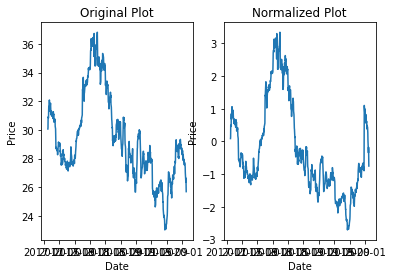

In [89]:

fig, axs = plt.subplots(1,2)
axs[0].plot('Date','HMC', data = stck_av)
axs[0].set_title('Original Plot')
axs[1].plot('HMC',data = stck_norm)
axs[1].set_title('Normalized Plot')


for ax in axs.flat:
    ax.set(xlabel='Date', ylabel='Price')

In [82]:
from sklearn.linear_model import LinearRegression

In [151]:
X1 = stck_norm.shift(periods=30).reset_index().drop(range(0,90))
X2 = stck_norm.shift(periods=60).reset_index().drop(range(0,90))
X3 = stck_norm.shift(periods=90).reset_index().drop(range(0,90))

pasts = pd.DataFrame(data=X1['HMC']).rename(columns={'HMC': 'M1'})
pasts['M2'] = X2['HMC']
pasts['M3'] = X3['HMC'] 
pasts.head()

,M1,M2,M3
90,-0.409867,0.669375,0.088800
91,-0.407458,0.587468,0.134571
92,-0.474911,0.575423,0.495925
93,-0.494183,0.585059,0.459790
94,-0.448412,0.317657,0.746463


In [155]:
y = stck_norm['HMC'].reset_index().drop(range(0,90)).drop(columns=['Date'])

In [156]:
model = LinearRegression().fit(pasts, y)
m = model.coef_[0]
b = model.intercept_

In [157]:
print(m,b)

[ 1.12280709 -0.02868167 -0.37972303] [0.00090113]


In [158]:
z = m[0]*pasts['M1'] + m[1]*pasts['M2'] + m[2]*pasts['M3'] + b

In [159]:
z.head()

90   -0.512219
91   -0.524545
92   -0.737150
93   -0.745344
94   -0.795139
dtype: float64

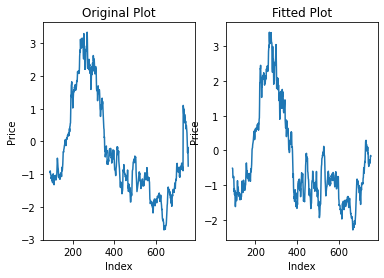

In [160]:
fig, axs = plt.subplots(1,2)
axs[0].plot('HMC',data = y)
axs[0].set_title('Original Plot')
axs[1].plot(z)
axs[1].set_title('Fitted Plot')


for ax in axs.flat:
    ax.set(xlabel='Index', ylabel='Price')

In [163]:
import sklearn
r_squared = sklearn.metrics.r2_score(y['HMC'],z,multioutput='uniform_average')
r_squared

0.8241927456596685